In [82]:
# import libraries

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pandas import json_normalize
import datetime
import typing
import time
import seaborn as sns

In [83]:
# Import dataset

df = pd.read_csv("pet-adoption.csv")
df.drop(['id', 'organization_id', 'url', 'species','organization_animal_id','tags', 'photos','primary_photo_cropped', 'videos', 'distance', 'contact', '_links', 'description', 'colors'], axis=1, inplace=True)
df.head()

,type,breeds,age,gender,size,coat,attributes,environment,name,status,status_changed_at,published_at
0,Dog,"{'primary': 'Terrier', 'secondary': 'Pug', 'mi...",Young,Male,Small,Short,"{'spayed_neutered': 'True', 'house_trained': '...","{'children': 'None', 'dogs': 'True', 'cats': '...",Ruff,adopted,2020-08-16 18:21:00+00:00,2020-07-21 20:52:42+00:00
1,Dog,"{'primary': 'German Shepherd Dog', 'secondary'...",Adult,Female,Medium,Medium,"{'spayed_neutered': 'True', 'house_trained': '...","{'children': 'None', 'dogs': 'None', 'cats': '...",Delilah,adopted,2020-07-31 01:39:20+00:00,2020-07-21 13:17:11+00:00
2,Dog,"{'primary': 'Dogue de Bordeaux', 'secondary': ...",Adult,Male,Extra Large,None,"{'spayed_neutered': 'True', 'house_trained': '...","{'children': 'None', 'dogs': 'None', 'cats': '...",Red,adoptable,2020-07-21 14:00:23+00:00,2020-07-21 14:00:23+00:00
3,Dog,"{'primary': 'Labrador Retriever', 'secondary':...",Young,Male,Medium,None,"{'spayed_neutered': 'True', 'house_trained': '...","{'children': 'True', 'dogs': 'True', 'cats': '...",Louie,adopted,2020-07-26 15:50:42+00:00,2020-07-21 20:05:39+00:00
4,Dog,"{'primary': 'Border Collie', 'secondary': 'Non...",Adult,Male,Medium,Long,"{'spayed_neutered': 'True', 'house_trained': '...","{'children': 'None', 'dogs': 'None', 'cats': '...",Kenny,adopted,2020-07-23 16:00:20+00:00,2020-07-21 17:17:43+00:00


In [84]:
# convert json to data

values = [json.loads(value.replace("'", "\"")) for value in df['attributes'].values]
df1 = json_normalize(values)
df1.head()

col = df.columns.difference(['attributes'])
df = pd.concat([df[col], df1],axis=1)
df.head()

,age,breeds,coat,environment,gender,name,published_at,size,status,status_changed_at,type,spayed_neutered,house_trained,declawed,special_needs,shots_current
0,Young,"{'primary': 'Terrier', 'secondary': 'Pug', 'mi...",Short,"{'children': 'None', 'dogs': 'True', 'cats': '...",Male,Ruff,2020-07-21 20:52:42+00:00,Small,adopted,2020-08-16 18:21:00+00:00,Dog,True,True,None,False,True
1,Adult,"{'primary': 'German Shepherd Dog', 'secondary'...",Medium,"{'children': 'None', 'dogs': 'None', 'cats': '...",Female,Delilah,2020-07-21 13:17:11+00:00,Medium,adopted,2020-07-31 01:39:20+00:00,Dog,True,False,None,False,True
2,Adult,"{'primary': 'Dogue de Bordeaux', 'secondary': ...",None,"{'children': 'None', 'dogs': 'None', 'cats': '...",Male,Red,2020-07-21 14:00:23+00:00,Extra Large,adoptable,2020-07-21 14:00:23+00:00,Dog,True,False,None,False,True
3,Young,"{'primary': 'Labrador Retriever', 'secondary':...",None,"{'children': 'True', 'dogs': 'True', 'cats': '...",Male,Louie,2020-07-21 20:05:39+00:00,Medium,adopted,2020-07-26 15:50:42+00:00,Dog,True,True,None,False,True
4,Adult,"{'primary': 'Border Collie', 'secondary': 'Non...",Long,"{'children': 'None', 'dogs': 'None', 'cats': '...",Male,Kenny,2020-07-21 17:17:43+00:00,Medium,adopted,2020-07-23 16:00:20+00:00,Dog,True,True,None,False,True


In [85]:
values = [json.loads(value.replace("'", "\"")) for value in df['environment'].values]

df1 = json_normalize(values)
df1.head()

col = df.columns.difference(['environment'])
df = pd.concat([df[col], df1],axis=1)
df.head()

,age,breeds,coat,declawed,gender,house_trained,name,published_at,shots_current,size,spayed_neutered,special_needs,status,status_changed_at,type,children,dogs,cats
0,Young,"{'primary': 'Terrier', 'secondary': 'Pug', 'mi...",Short,None,Male,True,Ruff,2020-07-21 20:52:42+00:00,True,Small,True,False,adopted,2020-08-16 18:21:00+00:00,Dog,None,True,None
1,Adult,"{'primary': 'German Shepherd Dog', 'secondary'...",Medium,None,Female,False,Delilah,2020-07-21 13:17:11+00:00,True,Medium,True,False,adopted,2020-07-31 01:39:20+00:00,Dog,None,None,None
2,Adult,"{'primary': 'Dogue de Bordeaux', 'secondary': ...",None,None,Male,False,Red,2020-07-21 14:00:23+00:00,True,Extra Large,True,False,adoptable,2020-07-21 14:00:23+00:00,Dog,None,None,None
3,Young,"{'primary': 'Labrador Retriever', 'secondary':...",None,None,Male,True,Louie,2020-07-21 20:05:39+00:00,True,Medium,True,False,adopted,2020-07-26 15:50:42+00:00,Dog,True,True,True
4,Adult,"{'primary': 'Border Collie', 'secondary': 'Non...",Long,None,Male,True,Kenny,2020-07-21 17:17:43+00:00,True,Medium,True,False,adopted,2020-07-23 16:00:20+00:00,Dog,None,None,None


In [86]:
# # convert json to data

values = [json.loads(value.replace("'", "\"")) for value in df['breeds'].values]
df1 = json_normalize(values)
df1.head()

col = df.columns.difference(['breeds'])
df = pd.concat([df[col], df1],axis=1)
df.head()

,age,cats,children,coat,declawed,dogs,gender,house_trained,name,published_at,...,size,spayed_neutered,special_needs,status,status_changed_at,type,primary,secondary,mixed,unknown
0,Young,None,None,Short,None,True,Male,True,Ruff,2020-07-21 20:52:42+00:00,...,Small,True,False,adopted,2020-08-16 18:21:00+00:00,Dog,Terrier,Pug,True,False
1,Adult,None,None,Medium,None,None,Female,False,Delilah,2020-07-21 13:17:11+00:00,...,Medium,True,False,adopted,2020-07-31 01:39:20+00:00,Dog,German Shepherd Dog,None,True,False
2,Adult,None,None,None,None,None,Male,False,Red,2020-07-21 14:00:23+00:00,...,Extra Large,True,False,adoptable,2020-07-21 14:00:23+00:00,Dog,Dogue de Bordeaux,Mixed Breed,True,False
3,Young,True,True,None,None,True,Male,True,Louie,2020-07-21 20:05:39+00:00,...,Medium,True,False,adopted,2020-07-26 15:50:42+00:00,Dog,Labrador Retriever,Black Mouth Cur,True,False
4,Adult,None,None,Long,None,None,Male,True,Kenny,2020-07-21 17:17:43+00:00,...,Medium,True,False,adopted,2020-07-23 16:00:20+00:00,Dog,Border Collie,None,True,False


In [87]:
#  drop columns

df = df.loc[:, ['published_at', 'status_changed_at', 'status','type', 'primary','name', 'gender','age', 'size', 'coat', 'house_trained', 'shots_current', 'spayed_neutered', 'special_needs', 'children', 'dogs', 'cats']]
df.head()

,published_at,status_changed_at,status,type,primary,name,gender,age,size,coat,house_trained,shots_current,spayed_neutered,special_needs,children,dogs,cats
0,2020-07-21 20:52:42+00:00,2020-08-16 18:21:00+00:00,adopted,Dog,Terrier,Ruff,Male,Young,Small,Short,True,True,True,False,None,True,None
1,2020-07-21 13:17:11+00:00,2020-07-31 01:39:20+00:00,adopted,Dog,German Shepherd Dog,Delilah,Female,Adult,Medium,Medium,False,True,True,False,None,None,None
2,2020-07-21 14:00:23+00:00,2020-07-21 14:00:23+00:00,adoptable,Dog,Dogue de Bordeaux,Red,Male,Adult,Extra Large,None,False,True,True,False,None,None,None
3,2020-07-21 20:05:39+00:00,2020-07-26 15:50:42+00:00,adopted,Dog,Labrador Retriever,Louie,Male,Young,Medium,None,True,True,True,False,True,True,True
4,2020-07-21 17:17:43+00:00,2020-07-23 16:00:20+00:00,adopted,Dog,Border Collie,Kenny,Male,Adult,Medium,Long,True,True,True,False,None,None,None


In [89]:
time_in = df.iloc[0]['published_at']
time_in = datetime.datetime.strptime(time_in[0:10], "%Y-%m-%d")
time_out = df.iloc[0]['status_changed_at']
time_out = datetime.datetime.strptime(time_out[0:10], "%Y-%m-%d")
time_out - time_in 

datetime.datetime(2020, 8, 16, 0, 0)

In [91]:
# make outcome variable

days_in_rescue = []

for i, value in enumerate(df['published_at']):
    time_in = df.iloc[i]['published_at']
    time_in = datetime.datetime.strptime(time_in[0:10], "%Y-%m-%d")
    time_out = df.iloc[i]['status_changed_at']
    time_out = datetime.datetime.strptime(time_out[0:10], "%Y-%m-%d")
    time_difference = time_out - time_in
    days_in_rescue.append(time_difference.days)

df['time_in_rescue'] = days_in_rescue
df.drop(['published_at', 'status_changed_at'], axis=1, inplace=True)
df.head()

,status,type,primary,name,gender,age,size,coat,house_trained,shots_current,spayed_neutered,special_needs,children,dogs,cats,time_in_rescue
0,adopted,Dog,Terrier,Ruff,Male,Young,Small,Short,True,True,True,False,None,True,None,26
1,adopted,Dog,German Shepherd Dog,Delilah,Female,Adult,Medium,Medium,False,True,True,False,None,None,None,10
2,adoptable,Dog,Dogue de Bordeaux,Red,Male,Adult,Extra Large,None,False,True,True,False,None,None,None,0
3,adopted,Dog,Labrador Retriever,Louie,Male,Young,Medium,None,True,True,True,False,True,True,True,5
4,adopted,Dog,Border Collie,Kenny,Male,Adult,Medium,Long,True,True,True,False,None,None,None,2


In [92]:
# drop adoptable dogs

df.drop(df[df.status == 'adoptable'].index, inplace=True)
df

,status,type,primary,name,gender,age,size,coat,house_trained,shots_current,spayed_neutered,special_needs,children,dogs,cats,time_in_rescue
0,adopted,Dog,Terrier,Ruff,Male,Young,Small,Short,True,True,True,False,None,True,None,26
1,adopted,Dog,German Shepherd Dog,Delilah,Female,Adult,Medium,Medium,False,True,True,False,None,None,None,10
3,adopted,Dog,Labrador Retriever,Louie,Male,Young,Medium,None,True,True,True,False,True,True,True,5
4,adopted,Dog,Border Collie,Kenny,Male,Adult,Medium,Long,True,True,True,False,None,None,None,2
5,adopted,Dog,Labrador Retriever,Stormy,Male,Senior,Large,Medium,True,True,True,False,True,True,True,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,adopted,Dog,Shepherd,Perch,Male,Baby,Medium,Short,False,True,True,False,True,True,None,0
717,adopted,Dog,Boxer,Dina,Female,Young,Medium,Short,False,True,True,False,None,None,None,9
719,adopted,Dog,Terrier,Omar,Male,Baby,Medium,Medium,True,True,True,False,None,True,None,26
720,adopted,Dog,Shepherd,Dora,Female,Baby,Large,None,False,True,False,False,True,True,None,0


In [93]:
# transform true false to 1 -0 

data1_bool = df.copy()
data1_bool['house_trained'] = data1_bool['house_trained'].map({'True': True, 'False': False})
data1_bool['shots_current'] = data1_bool['shots_current'].map({'True': True, 'False': False})
data1_bool['spayed_neutered'] = data1_bool['spayed_neutered'].map({'True': True, 'False': False})
data1_bool['children'] = data1_bool['children'].map({'True': True, 'None': False, 'False' : False})
data1_bool['dogs'] = data1_bool['dogs'].map({'True': True, 'None': False, 'False' : False})
data1_bool['cats'] = data1_bool['cats'].map({'True': True, 'None': False, 'False' : False})
data1_bool['special_needs'] = data1_bool['special_needs'].map({'True': True, 'None': False, 'False' : False})
data1_bool.head()

,status,type,primary,name,gender,age,size,coat,house_trained,shots_current,spayed_neutered,special_needs,children,dogs,cats,time_in_rescue
0,adopted,Dog,Terrier,Ruff,Male,Young,Small,Short,True,True,True,False,False,True,False,26
1,adopted,Dog,German Shepherd Dog,Delilah,Female,Adult,Medium,Medium,False,True,True,False,False,False,False,10
3,adopted,Dog,Labrador Retriever,Louie,Male,Young,Medium,None,True,True,True,False,True,True,True,5
4,adopted,Dog,Border Collie,Kenny,Male,Adult,Medium,Long,True,True,True,False,False,False,False,2
5,adopted,Dog,Labrador Retriever,Stormy,Male,Senior,Large,Medium,True,True,True,False,True,True,True,12


In [94]:
data1_bool["house_trained"] = data1_bool["house_trained"].astype(int)
data1_bool["shots_current"] = data1_bool["shots_current"].astype(int)
data1_bool["spayed_neutered"] = data1_bool["spayed_neutered"].astype(int)
data1_bool["special_needs"] = data1_bool["special_needs"].astype(int)

In [95]:

data1_bool["children"] = data1_bool["children"].astype(int)
data1_bool["dogs"] = data1_bool["dogs"].astype(int)
data1_bool["cats"] = data1_bool["cats"].astype(int)

In [96]:
# update df
df = data1_bool
df.head()

,status,type,primary,name,gender,age,size,coat,house_trained,shots_current,spayed_neutered,special_needs,children,dogs,cats,time_in_rescue
0,adopted,Dog,Terrier,Ruff,Male,Young,Small,Short,1,1,1,0,0,1,0,26
1,adopted,Dog,German Shepherd Dog,Delilah,Female,Adult,Medium,Medium,0,1,1,0,0,0,0,10
3,adopted,Dog,Labrador Retriever,Louie,Male,Young,Medium,None,1,1,1,0,1,1,1,5
4,adopted,Dog,Border Collie,Kenny,Male,Adult,Medium,Long,1,1,1,0,0,0,0,2
5,adopted,Dog,Labrador Retriever,Stormy,Male,Senior,Large,Medium,1,1,1,0,1,1,1,12


In [97]:
# check for missing data gives 0 missing data.

df.isnull().sum()

status             0
type               0
primary            0
name               0
gender             0
age                0
size               0
coat               0
house_trained      0
shots_current      0
spayed_neutered    0
special_needs      0
children           0
dogs               0
cats               0
time_in_rescue     0
dtype: int64

In [98]:
# set x and y

y = df['time_in_rescue']
x = df[['house_trained', 'shots_current', 'spayed_neutered', 'special_needs', 'children', 'dogs', 'cats']]

In [99]:
# show correlation matrix

df.corr()

/var/folders/bx/c7_76bgj2zs1_dhl31l18hxc0000gp/T/ipykernel_2557/796203143.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,house_trained,shots_current,spayed_neutered,special_needs,children,dogs,cats,time_in_rescue
house_trained,1.000000,0.163006,0.243611,0.121479,0.281518,0.263965,0.077728,0.099749
shots_current,0.163006,1.000000,0.495382,0.062168,0.182305,0.215743,0.089081,0.127210
spayed_neutered,0.243611,0.495382,1.000000,0.043912,0.104754,0.121716,0.080515,0.048914
special_needs,0.121479,0.062168,0.043912,1.000000,-0.018148,0.023483,0.005538,0.116175
children,0.281518,0.182305,0.104754,-0.018148,1.000000,0.588072,0.439604,-0.107371
dogs,0.263965,0.215743,0.121716,0.023483,0.588072,1.000000,0.399301,0.018029
cats,0.077728,0.089081,0.080515,0.005538,0.439604,0.399301,1.000000,-0.020369
time_in_rescue,0.099749,0.127210,0.048914,0.116175,-0.107371,0.018029,-0.020369,1.000000


In [100]:
# describe the data

# to no one in particular:
# i think it's funny how the mean of binary data is meaningful in the sense that
# it directly reflects the percentage of the population that has a certain attribute. 

df.describe()

,house_trained,shots_current,spayed_neutered,special_needs,children,dogs,cats,time_in_rescue
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,0.347826,0.824111,0.747036,0.017787,0.511858,0.697628,0.314229,7.019763
std,0.476752,0.381103,0.435141,0.132306,0.500354,0.459740,0.464668,6.933889
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,5.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,10.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,28.000000


<AxesSubplot: title={'center': 'Amount of dogs per breed that are adopted'}>

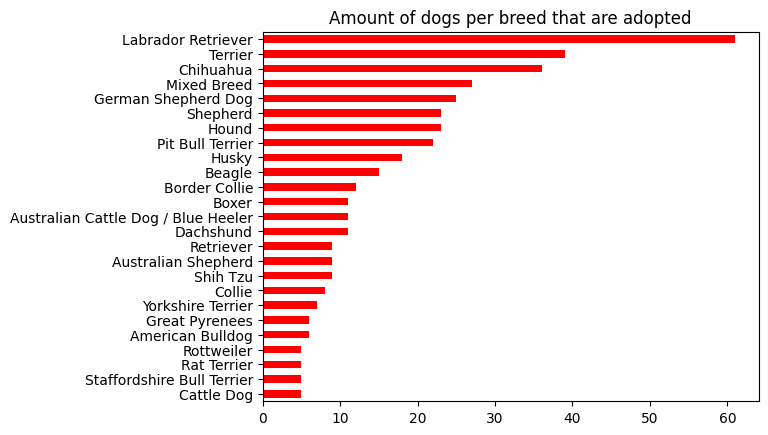

In [101]:
# show the most common types of dogs that enter and exit the animal shelter, for curiosity sake.

df['primary'].value_counts()[:25].sort_values().plot(kind='barh', title='Amount of dogs per breed that are adopted', color='red')

<AxesSubplot: title={'center': 'Age stratification of adopted dogs'}>

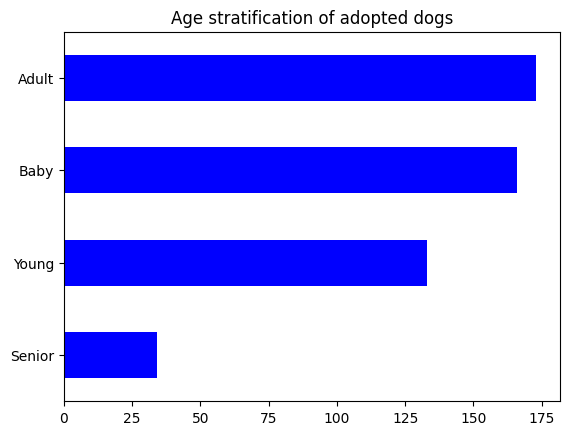

In [102]:
df['age'].value_counts().sort_values().plot(kind='barh', title='Age stratification of adopted dogs', color='blue')

Text(0.5, 1.0, 'Outcome variable histogram')

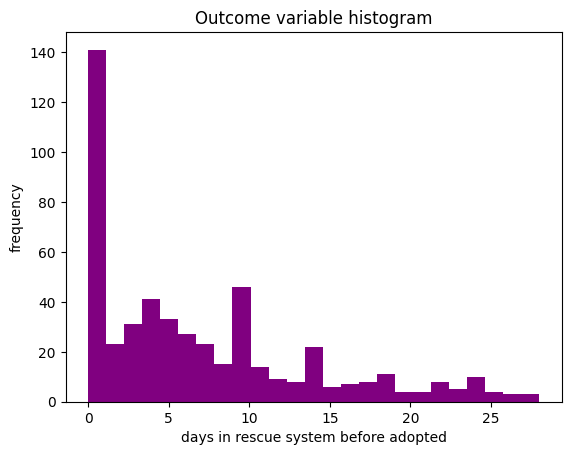

In [103]:
# plot outcome variable in historgram

plt.hist(df['time_in_rescue'], color='purple', bins=25)
plt.xlabel('days in rescue system before adopted')
plt.ylabel('frequency')
plt.title('Outcome variable histogram')

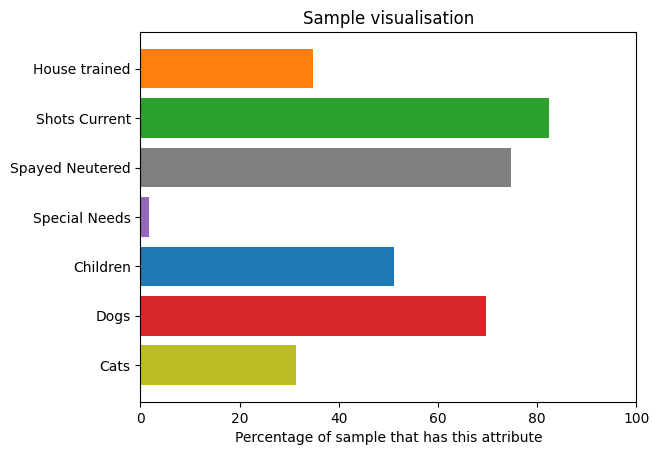

In [104]:
# Got most of this code from matplotlib docs https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html

Attributes = ('House trained', 'Shots Current', 'Spayed Neutered', 'Special Needs', 'Children', 'Dogs', 'Cats')
y_pos = np.arange(len(Attributes))
averages = df[['house_trained', 'shots_current', 'spayed_neutered', 'special_needs', 'children', 'dogs', 'cats']].mean() * 100
bar_colors = ['tab:orange', 'tab:green', 'tab:gray', 'tab:purple', 'tab:blue', 'tab:red', 'tab:olive']

fig, ax = plt.subplots()
ax.barh(y_pos, averages, align='center', color=bar_colors)
ax.set_yticks(y_pos, labels=Attributes)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Percentage of sample that has this attribute')
ax.set_title('Sample visualisation')
plt.xlim([0, 100])


plt.show()

In [105]:
# split in training and test data.

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=0.3, random_state=777)

In [106]:
from sklearn.linear_model import LinearRegression

model=LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [107]:
# at face value the model doesn't appear to be good at predicting the results. 

model.predict([[0, 1, 1, 0, 0, 0, 0]]) # outcome of data was 10 instead of 7,5

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([7.55299708])

In [108]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.02278825828990516

In [109]:
import statsmodels.api as sm

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         time_in_rescue   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     4.718
Date:                Wed, 14 Dec 2022   Prob (F-statistic):           3.83e-05
Time:                        16:35:25   Log-Likelihood:                -1681.1
No. Observations:                 506   AIC:                             3378.
Df Residuals:                     498   BIC:                             3412.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.3066      0.816     

Text(0.5, 1.0, 'Actual vs predicted')

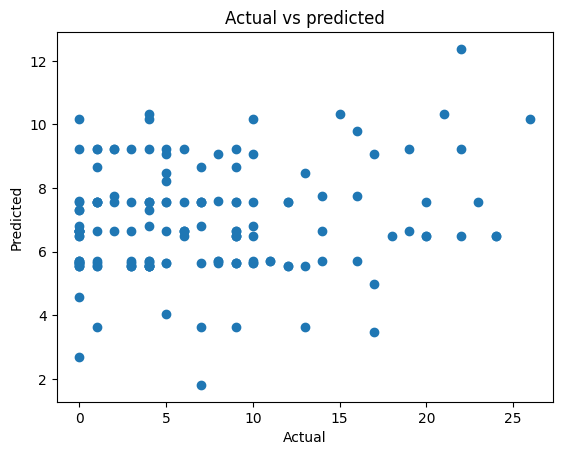

In [110]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs predicted')

In [111]:
x.head()

,const,house_trained,shots_current,spayed_neutered,special_needs,children,dogs,cats
0,1.0,1,1,1,0,0,1,0
1,1.0,0,1,1,0,0,0,0
3,1.0,1,1,1,0,1,1,1
4,1.0,1,1,1,0,0,0,0
5,1.0,1,1,1,0,1,1,1


In [112]:
# imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# got this code from https://enjoymachinelearning.com/blog/multivariate-polynomial-regression-python/

# set variables
x_values = x[['shots_current', 'house_trained', 'special_needs', 'children']]
y_values = y

# set degrees of freedom
degree=4

# set model
poly_model = PolynomialFeatures(degree=degree)

# transform data to have poly features
poly_x = poly_model.fit_transform(x_values)

# fitting the model
poly_model.fit(poly_x, y_values)

# add linear regression to the base of the model
regression_model = LinearRegression()
regression_model.fit(poly_x, y_values)

# making predictions with model.
y_pred = regression_model.predict(poly_x)

# calculate coefficiencies
regression_model.coef_

# calculate MSE
mean_squared_error(y_values, y_pred, squared=False)

6.652870258595444

In [113]:
r2_score(y_values, y_pred)

0.07759111494381443

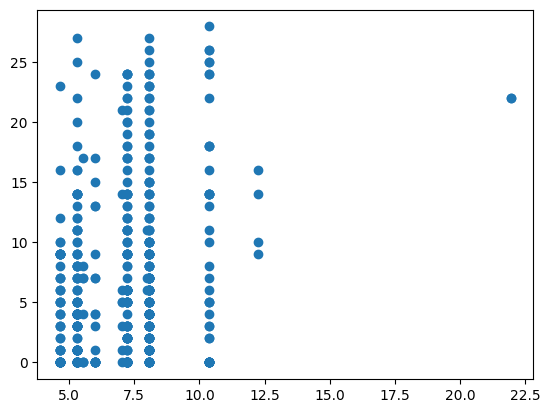

In [114]:
plt.scatter(y_pred, y_values)
plt.show()

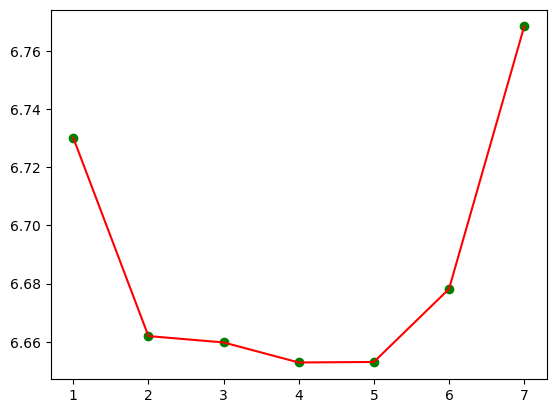

In [115]:
# got this code from https://enjoymachinelearning.com/blog/multivariate-polynomial-regression-python/

number_degrees = [1,2,3,4,5,6,7]
plt_mean_squared_error = []
for degree in number_degrees:

   poly_model = PolynomialFeatures(degree=degree)
  
   poly_x_values = poly_model.fit_transform(x_values)
   poly_model.fit(poly_x_values, y_values)
  
   regression_model = LinearRegression()
   regression_model.fit(poly_x_values, y_values)
   y_pred = regression_model.predict(poly_x_values)
  
   plt_mean_squared_error.append(mean_squared_error(y_values, y_pred, squared=False))

plt.scatter(number_degrees,plt_mean_squared_error, color="green")
plt.plot(number_degrees,plt_mean_squared_error, color="red") 

In [116]:
plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/site-packages/matplotlib/pyplot.py'>